In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 1 TB / available: 1 TB / percent used: 0.6 %


In [2]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly'

In [4]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1, memory_limit='60GB')
client

Client Scheduler: tcp://127.0.0.1:35941 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 720.00 GB


In [35]:
client.close()

In [5]:
ds = xr.open_mfdataset(path+'/*.nc', parallel=True)
# To add the missing index from 1994-11 to 1995-01
ds = ds.reindex(time=pd.date_range(ds.time[0].values, ds.time[-1].values, freq='M'))
ds

,Array,Chunk
Bytes,92.07 GB,2.70 GB
Shape,"(444, 3600, 7200)","(13, 3600, 7200)"
Count,375 Tasks,37 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,92.07 GB,2.70 GB
Shape,"(444, 3600, 7200)","(13, 3600, 7200)"
Count,375 Tasks,37 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


# /!\ Penser à rajouter 0 pour la période de 1994-11 à 1995-01 /!\

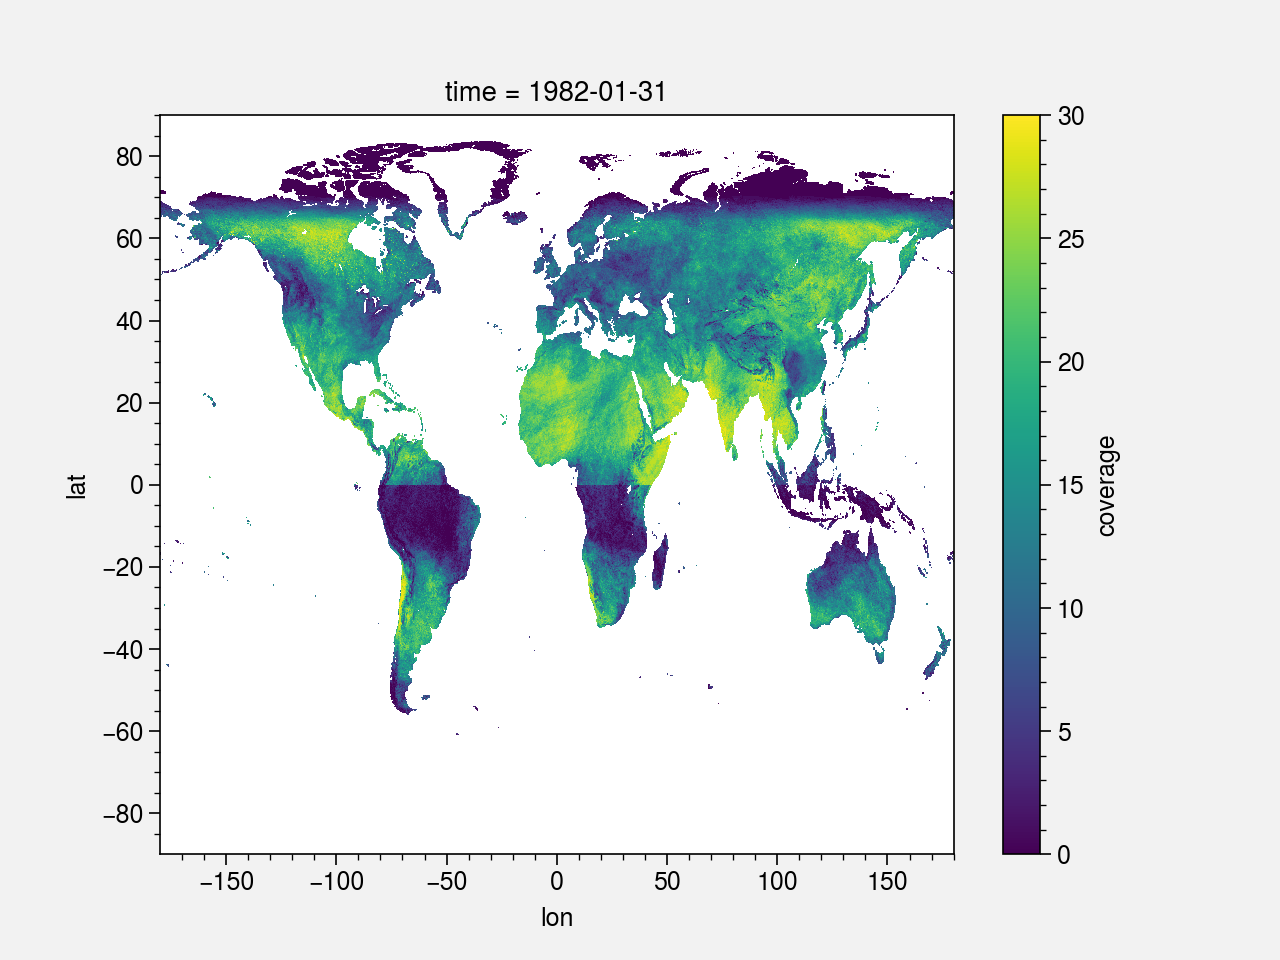

In [7]:
ds.coverage[0].where(ds.mask_water[0] != 210).where(ds.mask_ice[0] != 215).plot()

In [6]:
ds.coverage

,Array,Chunk
Bytes,92.07 GB,2.70 GB
Shape,"(444, 3600, 7200)","(13, 3600, 7200)"
Count,375 Tasks,37 Chunks
Type,float64,numpy.ndarray


In [8]:
coverage = ds.coverage.where(ds.mask_water[0] != 210).where(ds.mask_ice[0] != 215).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))
coverage.load()

<xarray.DataArray (time: 444)>
array([1.40329163e+01, 1.29765105e+01, 1.52353188e+01, 1.36446558e+01,
       1.17890205e+01, 1.40780081e+01, 1.63246727e+01, 1.63065555e+01,
       1.31392278e+01, 1.47751432e+01, 1.31403396e+01, 1.30751744e+01,
       1.40322471e+01, 1.38027164e+01, 1.51730142e+01, 1.38850573e+01,
       1.53639038e+01, 1.56372886e+01, 1.36587845e+01, 1.41807295e+01,
       1.22953030e+01, 1.58169206e+01, 1.43175645e+01, 1.34708267e+01,
       1.29814615e+01, 1.26487392e+01, 1.36399064e+01, 1.33172396e+01,
       1.56886146e+01, 1.53687403e+01, 1.42200744e+01, 1.70128815e+01,
       1.45081265e+01, 1.42510619e+01, 1.17502883e+01, 9.86971809e+00,
       1.21937713e+01, 1.00479892e+01, 1.37454693e+01, 1.43248446e+01,
       1.49338782e+01, 1.51959775e+01, 1.53451288e+01, 1.65358840e+01,
       1.54900959e+01, 1.40249799e+01, 1.43103677e+01, 1.38453808e+01,
       1.44720688e+01, 1.42421313e+01, 1.39386963e+01, 1.40123381e+01,
       1.52049253e+01, 1.55384346e+01, 1.60365153e+01, 1.64231649e+01,
       1.50408711e+01, 1.47482272e+01, 1.40182404e+01, 1.40673573e+01,
       1.50064234e+01, 1.38287045e+01, 1.56391663e+01, 1.47563369e+01,
       1.48404313e+01, 1.57749724e+01, 1.64642292e+01, 1.67360422e+01,
       1.53246549e+01, 1.42833693e+01, 1.39900700e+01, 1.28969567e+01,
       1.37974956e+01, 1.41732563e+01, 1.56731995e+01, 1.43010116e+01,
       1.52702558e+01, 1.59062594e+01, 1.66890340e+01, 1.63170728e+01,
...
       1.67270874e+01, 1.65908714e+01, 1.67468175e+01, 1.72322953e+01,
       1.69835493e+01, 1.62153046e+01, 1.47336102e+01, 1.48303236e+01,
       1.57105427e+01, 1.46346747e+01, 1.64099661e+01, 1.58668052e+01,
       1.62751098e+01, 1.58226411e+01, 1.67202295e+01, 1.73582145e+01,
       1.62420936e+01, 1.65118912e+01, 1.48616159e+01, 1.52448137e+01,
       1.59882812e+01, 1.45762966e+01, 1.61469604e+01, 1.52011346e+01,
       1.54979103e+01, 1.66620357e+01, 1.77214787e+01, 1.75463372e+01,
       1.65764311e+01, 1.65174053e+01, 1.48966382e+01, 1.48004787e+01,
       1.54429236e+01, 1.46889048e+01, 1.58640210e+01, 1.55681583e+01,
       1.61901274e+01, 1.67606717e+01, 1.73378615e+01, 1.76762188e+01,
       1.69091040e+01, 1.59891555e+01, 1.48568703e+01, 1.43727061e+01,
       1.50462566e+01, 1.58042633e+01, 1.49482740e+01, 1.51298653e+01,
       1.55983906e+01, 1.65117713e+01, 1.73823867e+01, 1.76748319e+01,
       1.63493203e+01, 1.56219754e+01, 1.46122635e+01, 1.40885179e+01,
       1.44187466e+01, 1.39473601e+01, 1.55455709e+01, 1.48483728e+01,
       1.57079155e+01, 1.64000092e+01, 1.48919244e+01, 1.74188105e+01,
       1.64456558e+01, 1.59641259e+01, 1.37793482e+01, 1.35469469e+01,
       1.45639411e+01, 1.31808803e+01, 1.56705185e+01, 1.50826817e+01,
       1.51923803e+01, 1.57700155e+01, 1.63986036e+01, 1.62475166e+01,
       1.50236824e+01, 1.32255329e+01, 1.01949677e+01, 1.01504451e+01])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31

In [30]:
coverage_interp = ds.coverage_interp.where(ds.mask_water[0] != 210).where(ds.mask_ice[0] != 215).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))
coverage_interp.load()

<xarray.DataArray (time: 444)>
array([2.42765521e+01, 2.30835423e+01, 2.68373791e+01, 2.62339550e+01,
       2.60440658e+01, 2.60380829e+01, 2.85962613e+01, 2.86269080e+01,
       2.59830108e+01, 2.69914469e+01, 2.48367817e+01, 2.39944855e+01,
       2.52301999e+01, 2.44265018e+01, 2.70959964e+01, 2.66459512e+01,
       2.80151957e+01, 2.74269988e+01, 2.52508990e+01, 2.61115049e+01,
       2.42026895e+01, 2.70746530e+01, 2.51245841e+01, 2.37649296e+01,
       2.39997208e+01, 2.34427622e+01, 2.58528709e+01, 2.61543978e+01,
       2.80041509e+01, 2.71498465e+01, 2.73522457e+01, 2.83424426e+01,
       2.65905062e+01, 2.63524876e+01, 2.22717964e+01, 2.08409298e+01,
       2.31192136e+01, 2.09083909e+01, 2.57449402e+01, 2.62871153e+01,
       2.78151065e+01, 2.72866238e+01, 2.82958671e+01, 2.84244464e+01,
       2.69329142e+01, 2.63368021e+01, 2.51544694e+01, 2.42451081e+01,
       2.50392673e+01, 2.41450128e+01, 2.61015987e+01, 2.62333467e+01,
       2.79020974e+01, 2.74935804e+01, 2.83010945e+01, 2.84724367e+01,
       2.63855686e+01, 2.68473597e+01, 2.49322872e+01, 2.47258341e+01,
       2.52577989e+01, 2.37447832e+01, 2.70454540e+01, 2.67767598e+01,
       2.82769907e+01, 2.74876036e+01, 2.83820156e+01, 2.84721455e+01,
       2.70939403e+01, 2.67854865e+01, 2.46583991e+01, 2.34172336e+01,
       2.47513660e+01, 2.43471265e+01, 2.62943767e+01, 2.67022726e+01,
       2.77867299e+01, 2.74266233e+01, 2.82541531e+01, 2.78728094e+01,
...
       2.79318643e+01, 2.74378559e+01, 2.82517362e+01, 2.85742076e+01,
       2.76753752e+01, 2.70753564e+01, 2.47529295e+01, 2.44291277e+01,
       2.47077972e+01, 2.33985874e+01, 2.70674164e+01, 2.66337706e+01,
       2.80464591e+01, 2.73496816e+01, 2.82009305e+01, 2.83423419e+01,
       2.68830618e+01, 2.72786690e+01, 2.51335099e+01, 2.45767121e+01,
       2.47651325e+01, 2.29546975e+01, 2.67291164e+01, 2.67685520e+01,
       2.79730101e+01, 2.75980180e+01, 2.86605710e+01, 2.84671872e+01,
       2.75448330e+01, 2.74052619e+01, 2.52676641e+01, 2.41997773e+01,
       2.52890611e+01, 2.38232960e+01, 2.69658439e+01, 2.64639155e+01,
       2.80500478e+01, 2.76341757e+01, 2.86659016e+01, 2.89361770e+01,
       2.79168513e+01, 2.77863070e+01, 2.52068099e+01, 2.47816626e+01,
       2.50813033e+01, 2.53372292e+01, 2.66819155e+01, 2.67948528e+01,
       2.81391783e+01, 2.77044285e+01, 2.84272002e+01, 2.89613366e+01,
       2.73218175e+01, 2.64217687e+01, 2.49017077e+01, 2.41608552e+01,
       2.42883837e+01, 2.33209975e+01, 2.62943033e+01, 2.64754572e+01,
       2.81044949e+01, 2.74819586e+01, 2.78733816e+01, 2.85321630e+01,
       2.72096998e+01, 2.66672483e+01, 2.35549180e+01, 2.30559879e+01,
       2.40381864e+01, 2.31024603e+01, 2.67110665e+01, 2.65976443e+01,
       2.78014688e+01, 2.71378599e+01, 2.80382915e+01, 2.81692314e+01,
       2.72226668e+01, 2.63452946e+01, 2.16055783e+01, 1.88140123e+01])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31

## Replace NaN values by 0 corresponding to the missing data from 1994-11 to 1995-01

### Initial time coverage

In [9]:
np.count_nonzero(np.isnan(coverage))

3

In [10]:
coverage[np.isnan(coverage)] = 0

In [26]:
np.count_nonzero(np.isnan(coverage))

0

In [29]:
tot_num_days = (pd.to_datetime(ds.time[-1].values) - pd.to_datetime(ds.time[0].values)).days
coverage.sum('time')/tot_num_days*100

<xarray.DataArray ()>
array(49.66661384)

### Interp time coverage

In [31]:
np.count_nonzero(np.isnan(coverage_interp))

3

In [32]:
coverage_interp[np.isnan(coverage_interp)] = 0

In [33]:
np.count_nonzero(np.isnan(coverage_interp))

0

In [34]:
tot_num_days = (pd.to_datetime(ds.time[-1].values) - pd.to_datetime(ds.time[0].values)).days
coverage_interp.sum('time')/tot_num_days*100

<xarray.DataArray ()>
array(85.51836368)